## Step 1: Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11
WINDOW_SEC = 3.0
HOP_SEC = 1.5
SR = 16000

BATCH_SIZE = 128
EPOCHS = 50

## Step 3: Load Label Map

In [3]:
import json

with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader (Multi-Label Ready)

In [4]:
def load_split(split):
    X, y = [], []

    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1  # multi-label compatible

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Train / Val / Test

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: CNN Architecture (For baseline model to avoid regularization)

In [6]:
def build_instrunet_baseline():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 7: Compile Model (BCE + SGD)

In [7]:
model = build_instrunet_baseline()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,307 (4.12 MB)

 Trainable params: 1,079,307 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_model_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

## Step 9: Class Weights Preparation

In [9]:
# Inverse frequency weighting
class_counts = y_train.sum(axis=0)
total_samples = y_train.shape[0]
num_classes = y_train.shape[1]

class_weights = {
    i: total_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
}

## Step 10: Train Model

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8193 - loss: 0.5738

37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.8764 - loss: 0.4489 - val_binary_accuracy: 0.9091 - val_loss: 0.3093 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3075

37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9091 - loss: 0.3062 - val_binary_accuracy: 0.9091 - val_loss: 0.3049 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 690s 19s/step - binary_accuracy: 0.9091 - loss: 0.3055 - val_binary_accuracy: 0.9091 - val_loss: 0.3067 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - binary_accuracy: 0.9091 - loss: 0.3055 - val_binary_accuracy: 0.9091 - val_loss: 0.3059 - learning_rate: 0.0100
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3045

37/37 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - binary_accuracy: 0.9091 - loss: 0.3053 - val_binary_accuracy: 0.9091 - val_loss: 0.3049 - learning_rate: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3055

37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9091 - loss: 0.3050 - val_binary_accuracy: 0.9091 - val_loss: 0.3046 - learning_rate: 0.0100
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3059

37/37 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - binary_accuracy: 0.9091 - loss: 0.3048 - val_binary_accuracy: 0.9091 - val_loss: 0.3038 - learning_rate: 0.0100
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9091 - loss: 0.3045 - val_binary_accuracy: 0.9091 - val_loss: 0.3041 - learning_rate: 0.0100
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - binary_accuracy: 0.9091 - loss: 0.3044 - val_binary_accuracy: 0.9091 - val_loss: 0.3042 - learning_rate: 0.0100
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - binary_accuracy: 0.9091 - loss: 0.3041 - val_binary_accuracy: 0.9091 - val_loss: 0.3038 - learning_rate: 0.0100
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3046

37/37 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - binary_accuracy: 0.9091 - loss: 0.3040 - val_binary_accuracy: 0.9091 - val_loss: 0.3030 - learning_rate: 0.0100
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9091 - loss: 0.3036 - val_binary_accuracy: 0.9091 - val_loss: 0.3037 - learning_rate: 0.0100
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3021

37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9091 - loss: 0.3035 - val_binary_accuracy: 0.9091 - val_loss: 0.3027 - learning_rate: 0.0100
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3042

37/37 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - binary_accuracy: 0.9091 - loss: 0.3031 - val_binary_accuracy: 0.9091 - val_loss: 0.3020 - learning_rate: 0.0100
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - binary_accuracy: 0.9091 - loss: 0.3027 - val_binary_accuracy: 0.9091 - val_loss: 0.3028 - learning_rate: 0.0100
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - binary_accuracy: 0.9091 - loss: 0.3023 - val_binary_accuracy: 0.9091 - val_loss: 0.3034 - learning_rate: 0.0100
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3026

37/37 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - binary_accuracy: 0.9091 - loss: 0.3018 - val_binary_accuracy: 0.9091 - val_loss: 0.3011 - learning_rate: 0.0100
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3023

37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9091 - loss: 0.3013 - val_binary_accuracy: 0.9091 - val_loss: 0.3008 - learning_rate: 0.0100
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - binary_accuracy: 0.9091 - loss: 0.3007 - val_binary_accuracy: 0.9091 - val_loss: 0.3013 - learning_rate: 0.0100
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3004

37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - binary_accuracy: 0.9091 - loss: 0.2997 - val_binary_accuracy: 0.9091 - val_loss: 0.2991 - learning_rate: 0.0100
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3007

37/37 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - binary_accuracy: 0.9091 - loss: 0.2989 - val_binary_accuracy: 0.9091 - val_loss: 0.2977 - learning_rate: 0.0100
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2979

37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - binary_accuracy: 0.9091 - loss: 0.2979 - val_binary_accuracy: 0.9091 - val_loss: 0.2973 - learning_rate: 0.0100
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2963

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9091 - loss: 0.2966 - val_binary_accuracy: 0.9091 - val_loss: 0.2954 - learning_rate: 0.0100
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2977

37/37 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - binary_accuracy: 0.9091 - loss: 0.2955 - val_binary_accuracy: 0.9091 - val_loss: 0.2949 - learning_rate: 0.0100
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9091 - loss: 0.2941 - val_binary_accuracy: 0.9091 - val_loss: 0.2951 - learning_rate: 0.0100
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2923

37/37 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - binary_accuracy: 0.9091 - loss: 0.2923 - val_binary_accuracy: 0.9091 - val_loss: 0.2933 - learning_rate: 0.0100
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2916

37/37 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - binary_accuracy: 0.9091 - loss: 0.2908 - val_binary_accuracy: 0.9090 - val_loss: 0.2908 - learning_rate: 0.0100
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2879

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9091 - loss: 0.2891 - val_binary_accuracy: 0.9091 - val_loss: 0.2885 - learning_rate: 0.0100
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2875

37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - binary_accuracy: 0.9091 - loss: 0.2876 - val_binary_accuracy: 0.9091 - val_loss: 0.2881 - learning_rate: 0.0100
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2864

37/37 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - binary_accuracy: 0.9091 - loss: 0.2864 - val_binary_accuracy: 0.9091 - val_loss: 0.2869 - learning_rate: 0.0100
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.2868

37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9091 - loss: 0.2852 - val_binary_accuracy: 0.9091 - val_loss: 0.2855 - learning_rate: 0.0100
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2852

37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9092 - loss: 0.2842 - val_binary_accuracy: 0.9091 - val_loss: 0.2851 - learning_rate: 0.0100
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2847

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9091 - loss: 0.2833 - val_binary_accuracy: 0.9092 - val_loss: 0.2847 - learning_rate: 0.0100
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2821

37/37 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step - binary_accuracy: 0.9092 - loss: 0.2824 - val_binary_accuracy: 0.9089 - val_loss: 0.2835 - learning_rate: 0.0100
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9090 - loss: 0.2810 - val_binary_accuracy: 0.9087 - val_loss: 0.2853 - learning_rate: 0.0100
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9092 - loss: 0.2822

37/37 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - binary_accuracy: 0.9091 - loss: 0.2809 - val_binary_accuracy: 0.9090 - val_loss: 0.2810 - learning_rate: 0.0100
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - binary_accuracy: 0.9092 - loss: 0.2793 - val_binary_accuracy: 0.9083 - val_loss: 0.2820 - learning_rate: 0.0100
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - binary_accuracy: 0.9092 - loss: 0.2789 - val_binary_accuracy: 0.9089 - val_loss: 0.2835 - learning_rate: 0.0100
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2770

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9092 - loss: 0.2780 - val_binary_accuracy: 0.9089 - val_loss: 0.2792 - learning_rate: 0.0100
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - binary_accuracy: 0.9089 - loss: 0.2768 - val_binary_accuracy: 0.9087 - val_loss: 0.2793 - learning_rate: 0.0100
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9092 - loss: 0.2765

37/37 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - binary_accuracy: 0.9091 - loss: 0.2754 - val_binary_accuracy: 0.9088 - val_loss: 0.2761 - learning_rate: 0.0100
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9092 - loss: 0.2729

37/37 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - binary_accuracy: 0.9092 - loss: 0.2742 - val_binary_accuracy: 0.9085 - val_loss: 0.2739 - learning_rate: 0.0100
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9090 - loss: 0.2727 - val_binary_accuracy: 0.9095 - val_loss: 0.2757 - learning_rate: 0.0100
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9092 - loss: 0.2714 - val_binary_accuracy: 0.9087 - val_loss: 0.2749 - learning_rate: 0.0100
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2724

37/37 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - binary_accuracy: 0.9093 - loss: 0.2706 - val_binary_accuracy: 0.9086 - val_loss: 0.2720 - learning_rate: 0.0100
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9101 - loss: 0.2683

37/37 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - binary_accuracy: 0.9093 - loss: 0.2692 - val_binary_accuracy: 0.9094 - val_loss: 0.2688 - learning_rate: 0.0100
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9094 - loss: 0.2687 - val_binary_accuracy: 0.9084 - val_loss: 0.2716 - learning_rate: 0.0100
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - binary_accuracy: 0.9097 - loss: 0.2662 - val_binary_accuracy: 0.9088 - val_loss: 0.2693 - learning_rate: 0.0100
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9100 - loss: 0.2654

37/37 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - binary_accuracy: 0.9098 - loss: 0.2647 - val_binary_accuracy: 0.9095 - val_loss: 0.2666 - learning_rate: 0.0100
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9101 - loss: 0.2625

37/37 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - binary_accuracy: 0.9100 - loss: 0.2626 - val_binary_accuracy: 0.9096 - val_loss: 0.2658 - learning_rate: 0.0100


## Step 11: Accuracy Curve

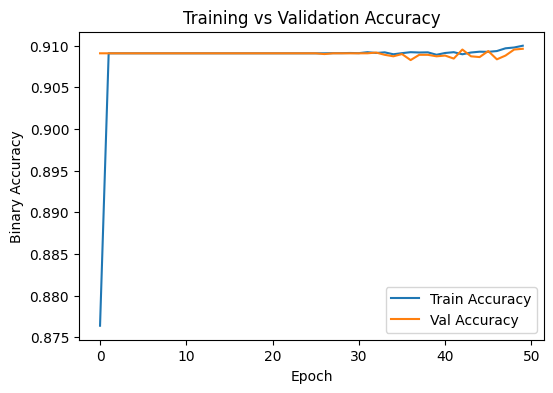

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 12: Training Loss and Validation Loss Curves

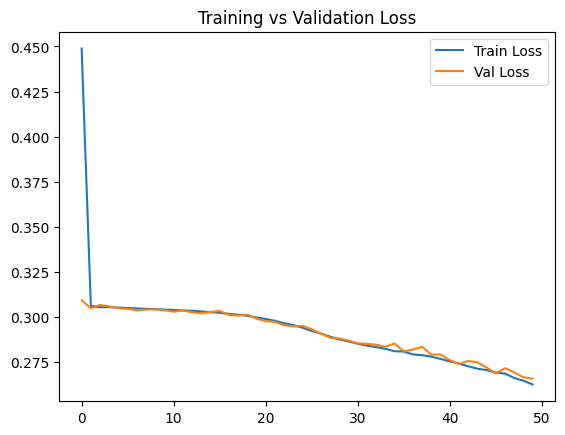

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 13: CNN Architecture (Model with regularization applied)

In [13]:
def build_instrunet_regularized():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 14: Model compile (BCE + SGD)

In [14]:
model = build_instrunet_regularized()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,227 (4.12 MB)

 Trainable params: 1,080,267 (4.12 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 15: Callbacks

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_regularized_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.5905 - loss: 0.6685

37/37 ━━━━━━━━━━━━━━━━━━━━ 241s 6s/step - binary_accuracy: 0.6710 - loss: 0.6361 - val_binary_accuracy: 0.9091 - val_loss: 0.5761 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.8486 - loss: 0.5327

37/37 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - binary_accuracy: 0.8702 - loss: 0.5017 - val_binary_accuracy: 0.8491 - val_loss: 0.4658 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9058 - loss: 0.4204

37/37 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - binary_accuracy: 0.9092 - loss: 0.3990 - val_binary_accuracy: 0.8302 - val_loss: 0.3997 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9144 - loss: 0.3432

37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9151 - loss: 0.3286 - val_binary_accuracy: 0.8288 - val_loss: 0.3785 - learning_rate: 0.0100
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9153 - loss: 0.2859 - val_binary_accuracy: 0.8288 - val_loss: 0.3863 - learning_rate: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9171 - loss: 0.2597 - val_binary_accuracy: 0.8288 - val_loss: 0.4176 - learning_rate: 0.0100
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - binary_accuracy: 0.9179 - loss: 0.2430 - val_binary_accuracy: 0.8307 - val_loss: 0.4219 - learning_rate: 0.0100
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - binary_accuracy: 0.9203 - loss: 0.2310 - val_binary_accuracy: 0.8385 - val_loss: 0.4191 - learning_rate: 0.0100
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9217 - loss: 0.2222 - val_binary_accuracy: 0.8547 - val_loss: 0.3942 - learning_rate: 0.0100
Epoch 10/50
37/37 ━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9249 - loss: 0.2152 - val_binary_accuracy: 0.8726 - val_loss: 0.3640 - learning_rate: 0.0050
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9264 - loss: 0.2113

37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9265 - loss: 0.2105 - val_binary_accuracy: 0.8780 - val_loss: 0.3420 - learning_rate: 0.0050
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9257 - loss: 0.2071

37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9263 - loss: 0.2077 - val_binary_accuracy: 0.8988 - val_loss: 0.2993 - learning_rate: 0.0050
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9268 - loss: 0.2068

37/37 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - binary_accuracy: 0.9269 - loss: 0.2047 - val_binary_accuracy: 0.9067 - val_loss: 0.2700 - learning_rate: 0.0050
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9271 - loss: 0.2033

37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9278 - loss: 0.2017 - val_binary_accuracy: 0.9097 - val_loss: 0.2522 - learning_rate: 0.0050
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9292 - loss: 0.2010

37/37 ━━━━━━━━━━━━━━━━━━━━ 267s 7s/step - binary_accuracy: 0.9290 - loss: 0.1995 - val_binary_accuracy: 0.9168 - val_loss: 0.2315 - learning_rate: 0.0050
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9294 - loss: 0.1970

37/37 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - binary_accuracy: 0.9301 - loss: 0.1964 - val_binary_accuracy: 0.9188 - val_loss: 0.2215 - learning_rate: 0.0050
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9309 - loss: 0.1932

37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9309 - loss: 0.1951 - val_binary_accuracy: 0.9222 - val_loss: 0.2159 - learning_rate: 0.0050
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9321 - loss: 0.1901

37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - binary_accuracy: 0.9316 - loss: 0.1917 - val_binary_accuracy: 0.9244 - val_loss: 0.2099 - learning_rate: 0.0050
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9328 - loss: 0.1881

37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9328 - loss: 0.1890 - val_binary_accuracy: 0.9260 - val_loss: 0.2071 - learning_rate: 0.0050
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9338 - loss: 0.1864 - val_binary_accuracy: 0.9248 - val_loss: 0.2073 - learning_rate: 0.0050
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9338 - loss: 0.1842 - val_binary_accuracy: 0.9225 - val_loss: 0.2187 - learning_rate: 0.0050
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - binary_accuracy: 0.9346 - loss: 0.1827 - val_binary_accuracy: 0.9259 - val_loss: 0.2075 - learning_rate: 0.0050
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9349 - loss: 0.1810 - val_binary_accuracy: 0.9263 - val_loss: 0.2109 - learning_rate: 0.0050
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9357 - loss: 0.1781

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9360 - loss: 0.1786 - val_binary_accuracy: 0.9277 - val_loss: 0.2004 - learning_rate: 0.0050
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9370 - loss: 0.1767

37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9371 - loss: 0.1758 - val_binary_accuracy: 0.9300 - val_loss: 0.1931 - learning_rate: 0.0050
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9379 - loss: 0.1742 - val_binary_accuracy: 0.9280 - val_loss: 0.1968 - learning_rate: 0.0050
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - binary_accuracy: 0.9391 - loss: 0.1718 - val_binary_accuracy: 0.9254 - val_loss: 0.2042 - learning_rate: 0.0050
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 347s 8s/step - binary_accuracy: 0.9389 - loss: 0.1704 - val_binary_accuracy: 0.9286 - val_loss: 0.1943 - learning_rate: 0.0050
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - binary_accuracy: 0.9409 - loss: 0.1669 - val_binary_accuracy: 0.9256 - val_loss: 0.2057 - learning_rate: 0.0050
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - binary_accuracy: 0.9415 - loss: 0.1640

37/37 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - binary_accuracy: 0.9408 - loss: 0.1658 - val_binary_accuracy: 0.9312 - val_loss: 0.1863 - learning_rate: 0.0050
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 314s 8s/step - binary_accuracy: 0.9420 - loss: 0.1638 - val_binary_accuracy: 0.9292 - val_loss: 0.1934 - learning_rate: 0.0050
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - binary_accuracy: 0.9411 - loss: 0.1628 - val_binary_accuracy: 0.9217 - val_loss: 0.2088 - learning_rate: 0.0050
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - binary_accuracy: 0.9421 - loss: 0.1594 - val_binary_accuracy: 0.9303 - val_loss: 0.1886 - learning_rate: 0.0050
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - binary_accuracy: 0.9426 - loss: 0.1580 - val_binary_accuracy: 0.9303 - val_loss: 0.1871 - learning_rate: 0.0050
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 332s 8s/step - binary_accuracy: 0.9433 - loss: 0.1558 - val_binary_accuracy: 0.9250 - val_loss: 0.2041 - learning_rate: 0.0050
Epoch 36/50
37/3

37/37 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - binary_accuracy: 0.9455 - loss: 0.1530 - val_binary_accuracy: 0.9317 - val_loss: 0.1822 - learning_rate: 0.0025
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9467 - loss: 0.1507

37/37 ━━━━━━━━━━━━━━━━━━━━ 298s 7s/step - binary_accuracy: 0.9458 - loss: 0.1510 - val_binary_accuracy: 0.9358 - val_loss: 0.1782 - learning_rate: 0.0025
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - binary_accuracy: 0.9463 - loss: 0.1502 - val_binary_accuracy: 0.9336 - val_loss: 0.1815 - learning_rate: 0.0025
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9466 - loss: 0.1504

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9465 - loss: 0.1500 - val_binary_accuracy: 0.9342 - val_loss: 0.1771 - learning_rate: 0.0025
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - binary_accuracy: 0.9475 - loss: 0.1484 - val_binary_accuracy: 0.9329 - val_loss: 0.1800 - learning_rate: 0.0025
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - binary_accuracy: 0.9478 - loss: 0.1477 - val_binary_accuracy: 0.9345 - val_loss: 0.1809 - learning_rate: 0.0025
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9489 - loss: 0.1456

37/37 ━━━━━━━━━━━━━━━━━━━━ 252s 6s/step - binary_accuracy: 0.9477 - loss: 0.1469 - val_binary_accuracy: 0.9342 - val_loss: 0.1751 - learning_rate: 0.0025
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9478 - loss: 0.1462

37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9480 - loss: 0.1450 - val_binary_accuracy: 0.9357 - val_loss: 0.1740 - learning_rate: 0.0025
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 272s 7s/step - binary_accuracy: 0.9488 - loss: 0.1447 - val_binary_accuracy: 0.9358 - val_loss: 0.1743 - learning_rate: 0.0025
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - binary_accuracy: 0.9487 - loss: 0.1428 - val_binary_accuracy: 0.9361 - val_loss: 0.1743 - learning_rate: 0.0025
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - binary_accuracy: 0.9492 - loss: 0.1428 - val_binary_accuracy: 0.9340 - val_loss: 0.1772 - learning_rate: 0.0025
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - binary_accuracy: 0.9494 - loss: 0.1412 - val_binary_accuracy: 0.9371 - val_loss: 0.1748 - learning_rate: 0.0025
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9511 - loss: 0.1376

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9500 - loss: 0.1398 - val_binary_accuracy: 0.9351 - val_loss: 0.1735 - learning_rate: 0.0025
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9511 - loss: 0.1380

37/37 ━━━━━━━━━━━━━━━━━━━━ 262s 6s/step - binary_accuracy: 0.9503 - loss: 0.1394 - val_binary_accuracy: 0.9371 - val_loss: 0.1709 - learning_rate: 0.0025
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9506 - loss: 0.1387 - val_binary_accuracy: 0.9348 - val_loss: 0.1787 - learning_rate: 0.0025


## Step 16: Accuracy Curve

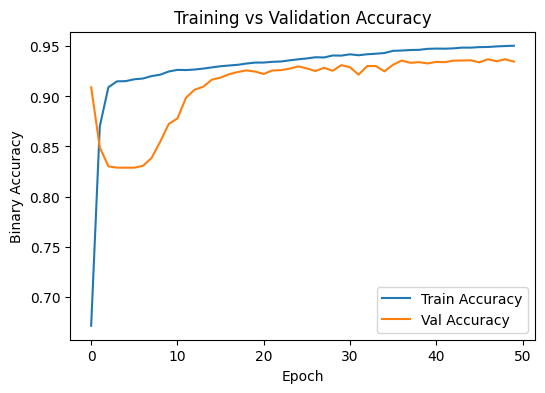

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 17:Training Loss and Validation Loss Curves

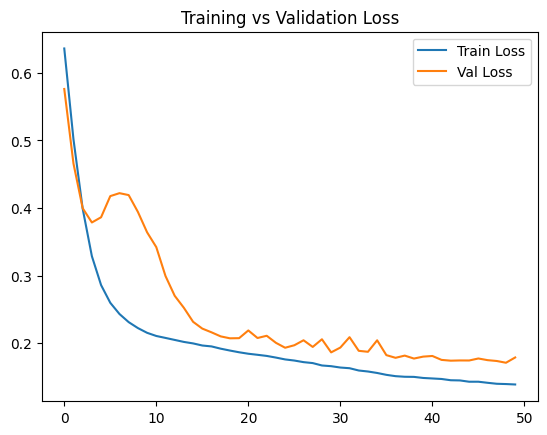

In [18]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 19: Model Evaluation with Thresholded Metrics

### (a) Generate probabilities

In [19]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step


### (b) Apply thresholding

In [20]:
THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

print(f"Using decision threshold = {THRESHOLD}")

Using decision threshold = 0.3


### (c) Global F1 scores

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

In [22]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("=== Global Metrics ===")
print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))

=== Global Metrics ===
Micro F1-score : 0.6282
Macro F1-score : 0.5989


### (d) Per-class Recall (CRITICAL)

In [23]:
recalls = recall_score(y_test, y_pred, average=None)

print("\n=== Per-class Recall ===")
for i, r in enumerate(recalls):
    print(f"{id_to_class[i]} : {round(r, 3)}")


=== Per-class Recall ===
cel : 0.379
cla : 0.539
flu : 0.574
gac : 0.779
gel : 0.491
org : 0.748
pia : 0.75
sax : 0.287
tru : 0.57
vio : 0.322
voi : 0.846


### (e) Per-class Precision

In [24]:
precisions = precision_score(
    y_test,
    y_pred,
    average=None,
    zero_division=0
)

print("\n=== Per-class Precision ===")
for i, p in enumerate(precisions):
    print(f"{id_to_class[i]} : {round(p, 3)}")


=== Per-class Precision ===
cel : 0.688
cla : 0.488
flu : 0.506
gac : 0.718
gel : 0.659
org : 0.706
pia : 0.704
sax : 0.771
tru : 0.731
vio : 0.622
voi : 0.762


### (f) Per-class Confusion Matrices

In [25]:
print("\n=== Per-class Confusion Matrices ===")
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


=== Per-class Confusion Matrices ===

Confusion Matrix for cel
[[938  10]
 [ 36  22]]

Confusion Matrix for cla
[[887  43]
 [ 35  41]]

Confusion Matrix for flu
[[900  38]
 [ 29  39]]

Confusion Matrix for gac
[[882  29]
 [ 21  74]]

Confusion Matrix for gel
[[863  29]
 [ 58  56]]

Confusion Matrix for org
[[871  32]
 [ 26  77]]

Confusion Matrix for pia
[[864  34]
 [ 27  81]]

Confusion Matrix for sax
[[904   8]
 [ 67  27]]

Confusion Matrix for tru
[[902  18]
 [ 37  49]]

Confusion Matrix for vio
[[902  17]
 [ 59  28]]

Confusion Matrix for voi
[[858  31]
 [ 18  99]]


### (g) Plotting of ROC-AUC curve (AUC score per class)

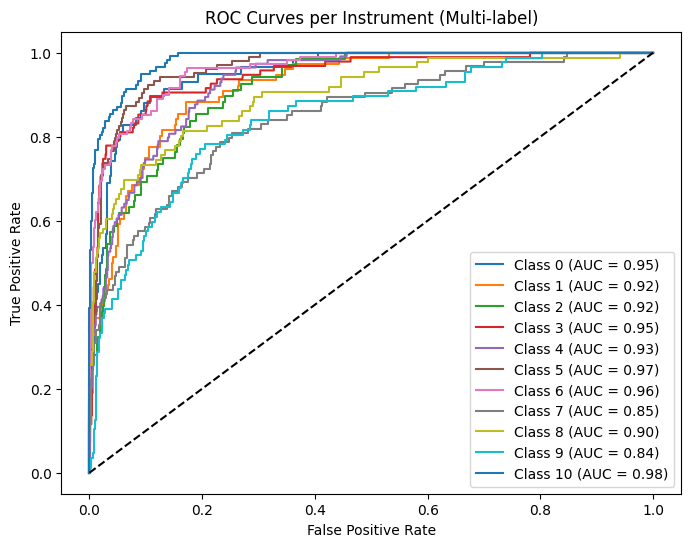

In [26]:
plt.figure(figsize=(8, 6))

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument (Multi-label)")
plt.legend()
plt.show()

### (h) Micro-Averaged and Macro-Averaged F1 Score

In [27]:
micro_auc = roc_auc_score(y_test, y_prob, average="micro")
print("Micro-average ROC–AUC:", micro_auc)

Micro-average ROC–AUC: 0.9272666189740286


In [28]:
macro_auc = roc_auc_score(y_test, y_prob, average="macro")
print("Macro-average ROC–AUC:", macro_auc)

Macro-average ROC–AUC: 0.9241066610441997
